<a href="https://colab.research.google.com/github/shroffp05/msca-37011-deep-learning/blob/main/Team1_Project_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Deep\ Learning/Dataset

/content/drive/My Drive/Deep Learning/Dataset


In [ ]:
%ls

best_model22.h5      best_model_eff.h5         labels.pkl
best_model2.h5       best_model.h5             Mild_Demented/
best_model_aug22.h5  best_model_resnet50.h5    Moderate_Demented/
best_model_aug23.h5  best_model_vgg16_aug2.h5  Non_Demented/
best_model_aug2.h5   best_model_vgg16_aug.h5   Very_Mild_Demented/
best_model_aug.h5    best_model_vgg16.h5


In [ ]:
# Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
from keras import applications
import cv2


import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline

In [ ]:
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
num_classes = 4

In [ ]:
IMG_WIDTH=128
IMG_HEIGHT=128

In [ ]:
## Create the dataset

def create_dataset():
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in classes:
        for file in os.listdir(os.path.join(dir1)):
            image_path= os.path.join(dir1,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name = create_dataset()

In [ ]:
## Image class subsets

mild_demented_images = img_data[:897]
moderate_demented_images = img_data[897:961]
non_demented_images = img_data[961:4161]
very_mild_demented_images = img_data[4161:6401]

label_mild_demented = class_name[:897]
label_moderate_demented = class_name[:961]
label_non_demented = class_name[:4161]
label_very_mild_demented = class_name[:6401]

In [ ]:
## Augment the dataset with transformed images
seq = iaa.Sequential([
    # random crops
    iaa.Crop(percent=(0, 0.1)),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.0001*255), per_channel=0.5),
], random_order=True) # apply augmenters in random order          

In [ ]:
## Augment mild demented images
images_aug_mild_demented = [seq(images=mild_demented_images) for i in range(3)]
images_aug_mild_demented_1 = []
for i in range(len(images_aug_mild_demented)):
  for j in range(len(images_aug_mild_demented[i])):
    images_aug_mild_demented_1.append(images_aug_mild_demented[i][j])

In [ ]:
## Augment moderate demented images
images_aug_moderate_demented = [seq(images=moderate_demented_images) for i in range(49)]
images_aug_moderate_demented_1 = []
for i in range(len(images_aug_moderate_demented)):
  for j in range(len(images_aug_moderate_demented[i])):
    images_aug_moderate_demented_1.append(images_aug_moderate_demented[i][j])

In [ ]:
## Augment very mild demented images
images_aug_very_mild_demented_1 = seq(images=very_mild_demented_images)

In [ ]:
## Get balanced classes

mild_demented_images = mild_demented_images + images_aug_mild_demented_1
moderate_demented_images = moderate_demented_images + images_aug_moderate_demented_1
very_mild_demented_images = very_mild_demented_images + images_aug_very_mild_demented_1

mild_demented_images = mild_demented_images[:3200]
very_mild_demented_images = very_mild_demented_images[:3200]

## Obtain the final balanced dataset
images_final_data = (
    mild_demented_images + 
    moderate_demented_images + 
    non_demented_images + 
    very_mild_demented_images
)

In [ ]:
## Get class labels
labels_data = []
for i in class_name:
  if i == 'Mild_Demented':
    labels_data.append(1)
  elif i == 'Moderate_Demented':
    labels_data.append(2)
  elif i == 'Non_Demented':
    labels_data.append(3)
  else:
    labels_data.append(0)

In [ ]:
## Split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = (
    train_test_split(np.array(images_final_data, np.float32), 
    np.array(labels_data, np.float32), test_size=0.3)
)

In [ ]:
## Preprocess data for the moel

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 128, 128)
    X_test = X_test.reshape(np.array(X_test).shape[0], 1, 128, 128)
    input_shape = (1, 128, 128)
else:
    X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
    input_shape = (128, 128, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (8960, 128, 128, 1)
8960 train samples
3840 test samples
y_train shape: (8960, 4)
y_test shape: (3840, 4)


Our Model

In [ ]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same', activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model2.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model2.add(keras.layers.Dropout(0.25))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(64,"relu"))
model2.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0

In [ ]:
model2.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
checkpoint_path = 'best_model_aug.h5'
chp = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = model2.fit(np.array(X_train), np.array(y_train),validation_data=(np.array(X_test), np.array(y_test)),epochs=100, batch_size=32, verbose=1, callbacks=[chp, es])

Epoch 1/100
280/280 [==============================] - 15s 14ms/step - loss: 1.1887 - accuracy: 0.4162 - val_loss: 1.0301 - val_accuracy: 0.4953
Epoch 2/100
280/280 [==============================] - 4s 13ms/step - loss: 1.0108 - accuracy: 0.4967 - val_loss: 0.9950 - val_accuracy: 0.5042
Epoch 3/100
280/280 [==============================] - 4s 13ms/step - loss: 0.9764 - accuracy: 0.5189 - val_loss: 0.9607 - val_accuracy: 0.5156
Epoch 4/100
280/280 [==============================] - 4s 13ms/step - loss: 0.9418 - accuracy: 0.5357 - val_loss: 0.9376 - val_accuracy: 0.5388
Epoch 5/100
280/280 [==============================] - 4s 13ms/step - loss: 0.8796 - accuracy: 0.5935 - val_loss: 0.8476 - val_accuracy: 0.6185
Epoch 6/100
280/280 [==============================] - 4s 13ms/step - loss: 0.8135 - accuracy: 0.6337 - val_loss: 0.7763 - val_accuracy: 0.6263
Epoch 7/100
280/280 [==============================] - 4s 13ms/step - loss: 0.7513 - accuracy: 0.6587 - val_loss: 0.7295 - val_accuracy

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test)

120/120 [==============================] - 1s 6ms/step - loss: 0.5437 - accuracy: 0.7505


Text(0.5, 1.0, 'Loss Curves')

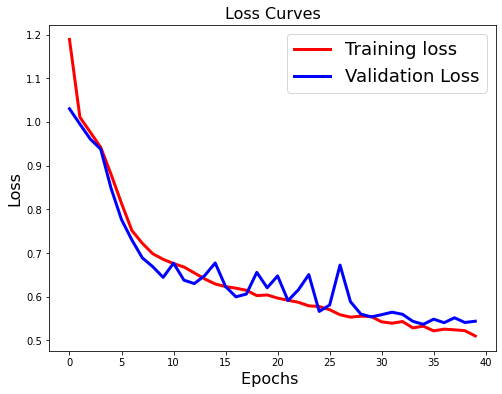

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
#Test the performance of our model on non-augmented images

In [ ]:
checkpoint_path2 = 'best_model2.h5'
chp2 = keras.callbacks.ModelCheckpoint(checkpoint_path2, save_best_only=True)

In [ ]:
hist2 = model2.fit(np.array(X_train), np.array(y_train),validation_data=(np.array(X_test), np.array(y_test)),epochs=100, batch_size=32, verbose=1, callbacks=[chp2, es])

Epoch 1/100
140/140 [==============================] - 13s 15ms/step - loss: 1.0584 - accuracy: 0.5020 - val_loss: 1.0447 - val_accuracy: 0.4932
Epoch 2/100
140/140 [==============================] - 2s 14ms/step - loss: 1.0405 - accuracy: 0.4929 - val_loss: 1.0417 - val_accuracy: 0.4932
Epoch 3/100
140/140 [==============================] - 2s 13ms/step - loss: 1.0451 - accuracy: 0.5000 - val_loss: 1.0377 - val_accuracy: 0.4932
Epoch 4/100
140/140 [==============================] - 2s 13ms/step - loss: 1.0370 - accuracy: 0.5029 - val_loss: 1.0319 - val_accuracy: 0.4932
Epoch 5/100
140/140 [==============================] - 2s 13ms/step - loss: 1.0347 - accuracy: 0.5029 - val_loss: 1.0271 - val_accuracy: 0.4932
Epoch 6/100
140/140 [==============================] - 2s 14ms/step - loss: 1.0220 - accuracy: 0.5042 - val_loss: 1.0154 - val_accuracy: 0.4979
Epoch 7/100
140/140 [==============================] - 2s 13ms/step - loss: 1.0188 - accuracy: 0.5045 - val_loss: 1.0049 - val_accuracy

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test)

60/60 [==============================] - 0s 6ms/step - loss: 0.1534 - accuracy: 0.9500


Text(0.5, 1.0, 'Loss Curves')

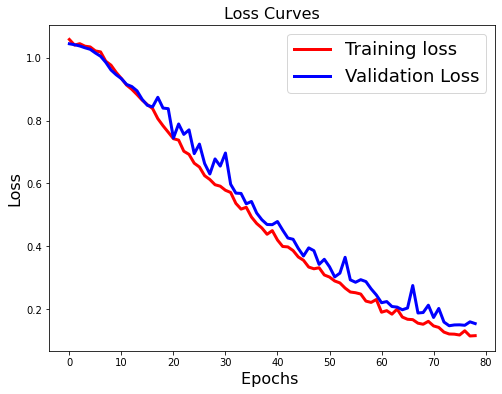

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(hist2.history['loss'],'r',linewidth=3.0)
plt.plot(hist2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
## Print predictions 

X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
predict_x=model_final.predict(X_test) 
predicted_classes=np.argmax(predict_x,axis=1)


# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

#print(correct_indices)
#print(incorrect_indices)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


<Figure size 720x720 with 0 Axes>

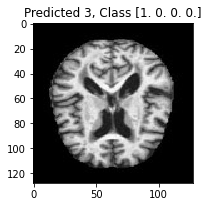

In [ ]:
#some of the correct results
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(128,128), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
#some of the incorrect predictions
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(128,128), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## VGG 16 Model 

In [ ]:
model = keras.applications.VGG16(weights = None, include_top=False, input_shape = (128, 128, 1))
## Freeze all layers
for layer in model.layers[:20]:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input, predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

checkpoint_path3 = 'best_model_vgg16.h5'
chp3 = keras.callbacks.ModelCheckpoint(checkpoint_path3, save_best_only=True)

In [ ]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# Fit model
epochs = 10 #0
batch_size=128
history = model_final.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test,y_test),shuffle=True, callbacks = [chp3, es])

Epoch 1/10
35/35 [==============================] - 1047s 30s/step - loss: 1.1473 - accuracy: 0.4862 - val_loss: 1.0442 - val_accuracy: 0.5125
Epoch 2/10
35/35 [==============================] - 1040s 30s/step - loss: 1.0408 - accuracy: 0.4949 - val_loss: 1.0366 - val_accuracy: 0.5125
Epoch 3/10
35/35 [==============================] - 1040s 30s/step - loss: 1.0388 - accuracy: 0.4946 - val_loss: 1.0382 - val_accuracy: 0.5125
Epoch 4/10
35/35 [==============================] - 1038s 30s/step - loss: 1.0366 - accuracy: 0.4944 - val_loss: 1.0386 - val_accuracy: 0.5125
Epoch 5/10
35/35 [==============================] - 1042s 30s/step - loss: 1.0368 - accuracy: 0.4949 - val_loss: 1.0391 - val_accuracy: 0.5125
Epoch 6/10
35/35 [==============================] - 1040s 30s/step - loss: 1.0383 - accuracy: 0.4946 - val_loss: 1.0413 - val_accuracy: 0.5125
Epoch 7/10
35/35 [==============================] - 1041s 30s/step - loss: 1.0395 - accuracy: 0.4920 - val_loss: 1.0420 - val_accuracy: 0.5125

In [ ]:
loss, accuracy = model_final.evaluate(X_test, y_test)

60/60 [==============================] - 327s 5s/step - loss: 1.0420 - accuracy: 0.5125


Text(0.5, 1.0, 'Loss Curves')

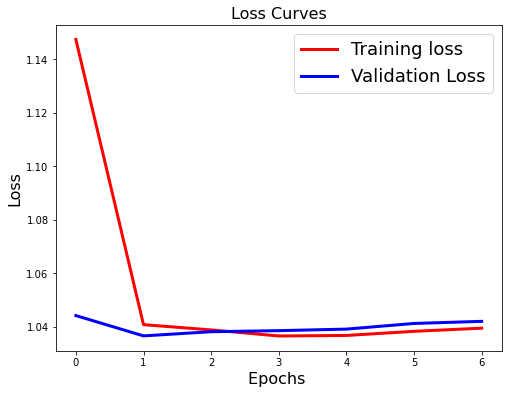

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)